In [6]:
import pandas as pd
import pandas_datareader.data as web
import numpy as np 
from openbb import obb
from datetime import date
import pandas as pd
import yfinance as yf
import statsmodels.api as sm
from datetime import date
import warnings
warnings.filterwarnings('ignore')

obb.user.preferences.output_type = 'dataframe'

In [7]:
tickers = [
    "AAPL", # Apple Inc.
    "MSFT",  # Microsoft Corporation
    "GOOGL", # Alphabet Inc. (Class A)
    "AMZN",  # Amazon.com Inc.
    "META",  # Meta Platforms Inc.
    "NVDA",  # NVIDIA Corporation
    "TSLA",  # Tesla Inc.
    "JPM",   # JPMorgan Chase & Co.
    "V",     # Visa Inc.
    "AMD", # AMD 
    "KO", # Coca Cola
    "SBUX", #Starbucks
    "PEP", # Pepsi
    "GE", # General Electric
    "GM", # General Motors
    "NFLX", # Netflix
    "RBLX", # Roblox
    "SONY", # Sony
    "WMT", # Walmart
    "IBM", # IBM
    "TGT", # target
    "COF" ,# Capital One,
    "PLTR", # Palantir,
    "MELI", # MercadoLibre
    "ROAD", #Construction
    "QUBT", # Quantum Computing
    "SHOP", # Shopify
    "ADBE" ,# Adobe
    "BRK-B",# berkshire hathaway
    "OKLO", # Oklo Inc
    "SMR", # Nuscale Power Corp
    "HOOD", # Robinhood 
    "GIL", # gildan
    "SPY" # SP 500  

]
end = pd.Timestamp.today().normalize()


In [8]:
def get_historical_Data(tickers):
    end_date = date.today().isoformat() 
    names = list()
    mapp = {}
    for i in tickers:
        data = pd.DataFrame(yf.download(i, end=end_date, progress=False))
        columns = data.columns
        
        data.columns = [i for i,stock in columns]
        mapp[i] = data
    

    return mapp

portolio = ['AAPL', 'NVDA', 'SBUX', 'GE','SPY']

def combined_portfolio_data(stock_portfolio):
    data = yf.download(stock_portfolio, end = end).Close

    return data.dropna()

In [9]:
porfolio_data = combined_portfolio_data(portolio) 

total_porfolio_returns = porfolio_data.pct_change().sum(axis = 1)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  5 of 5 completed


In [10]:
start = str(porfolio_data.index[0]).split(" ")[0]

In [11]:
total_porfolio_returns.name = 'porfolio_returns'


# market - risk free rate, small minus big stocks, high minus low, risk free
fama_french = web.DataReader('F-F_Research_Data_Factors_daily',
                             'famafrench',
                             start = start,
                             end = end)[0]

In [12]:
together = pd.concat([fama_french, total_porfolio_returns], axis = 1).dropna()

excess_returns = together.porfolio_returns - together.RF
excess_returns.name = "Excess Returns"

excess_returns

together

,Mkt-RF,SMB,HML,RF,porfolio_returns
Date,,,,,
1999-01-22,-0.66,0.41,0.15,0.02,0.000000
1999-01-25,0.67,-0.95,0.09,0.02,0.157913
1999-01-26,1.39,-0.25,-1.12,0.02,0.000303
1999-01-27,-0.74,0.10,-0.64,0.02,-0.068232
1999-01-28,1.63,-1.07,-0.50,0.02,0.052718
...,...,...,...,...,...
2025-09-24,-0.34,-0.36,0.99,0.02,-0.053707
2025-09-25,-0.58,-0.77,0.55,0.02,0.001917
2025-09-26,0.60,0.28,0.45,0.02,-0.009598


In [13]:
x  = together[['SMB', 'HML']]
x = sm.add_constant(x)

model = sm.OLS(excess_returns, x).fit()
hedge_weights = -model.params[1:]

-model.params[1:] * 100

SMB   -1.700653
HML    0.859030
dtype: float64

In [61]:
hedge_portfolio = (together[['SMB', 'HML']] @ hedge_weights).dropna()

hedge_portfolio_returns = total_porfolio_returns.loc[hedge_portfolio.index] + hedge_portfolio

hedge = pd.DataFrame({
    'unhedged_returns' : total_porfolio_returns.loc[hedge_portfolio_returns.index], 
    'hedged_returns' : hedge_portfolio_returns})

import math
sharpe_ratio = pd.DataFrame(hedge.mean() / hedge.std() * math.sqrt(252), columns = ['Sharpe Ratio of Full Porfolio'])

sharpe_ratio

,Sharpe Ratio of Full Porfolio
unhedged_returns,0.900253
hedged_returns,0.903015


In [153]:
data = get_historical_Data(tickers)


In [154]:
apple = data['AAPL']


In [223]:
# stock_info #
end = pd.Timestamp.today().normalize()
start = end - pd.DateOffset(years=10)

# look to webscrape this metric from fred 
# https://fred.stlouisfed.org/series/DGS10
risk_free = .00411
adjustment_factor = 0.0


sharpe_dictionary = {}
sortino_ratio_dictionary = {}

for stock, stock_data in data.items():
    stock_data['returns'] = stock_data['Close'].pct_change()

    
    idx = stock_data.index.slice_indexer(start=start, end=end)
    last_ten_years_data = stock_data.iloc[idx]
    YoY_cagr_ten = (last_ten_years_data['Close'].iloc[-1] / last_ten_years_data['Close'].iloc[0]) ** (1/10) - 1 
    sigma =  last_ten_years_data['returns'].std(ddof = 0) * np.sqrt(252)
    sharpe_ratio_ten_year = (YoY_cagr_ten - risk_free)  / (sigma)
    sharpe_dictionary[stock] = {"Sharpe Ratio Ten Year" : sharpe_ratio_ten_year}
    
    # sortino ratio
    returns_risk_adj = np.asanyarray(stock_data['returns'].dropna() - adjustment_factor)
    average_annual_return = returns_risk_adj.mean() * 252
    downside_difference = np.clip(returns_risk_adj, np.NINF, 0)
    np.square(downside_difference, out = downside_difference)
    annualized_downside_deviation = np.sqrt(downside_difference.mean()) * np.sqrt(252)
    sortino_ratio = average_annual_return / annualized_downside_deviation
    sortino_ratio_dictionary[stock] = {"Sortino Ratio" : sortino_ratio}

df_sharpe = pd.DataFrame(sharpe_dictionary)
df_sortino = pd.DataFrame(sortino_ratio_dictionary)

df_final = pd.concat([df_sharpe, df_sortino], axis = 0)

In [225]:
df_final

,AAPL,MSFT,GOOGL,AMZN,META,NVDA,TSLA,JPM,V,AMD,...,ROAD,QUBT,SHOP,ADBE,BRK-B,OKLO,SMR,HOOD,GIL,SPY
Sharpe Ratio Ten Year,0.874663,0.972090,0.764553,0.62662,0.480976,1.454875,0.653056,0.681983,0.624956,1.001086,...,0.489570,0.049910,0.798281,0.386727,0.693307,0.298694,0.074696,0.164732,0.231166,0.759440
Sortino Ratio,0.910928,1.264087,1.332194,1.20748,1.059493,1.271624,1.388504,0.789840,1.163871,0.675438,...,1.244779,4.681237,1.553640,0.940955,0.883415,1.757444,1.111659,1.162929,0.984649,0.901011


$$
\text{Sharpe Ratio} = \frac{\mathbb{E}\!\left[R_p - R_f\right]}{\sigma\!\left(R_p\right)}
$$

In [214]:
def sharpe_ratio(returns, adjustment_factor=0.0):
    returns_risk_adj = returns - adjustment_factor
    return (
        returns_risk_adj.mean() / returns_risk_adj.std()
    ) * np.sqrt(252)

<Axes: xlabel='Date'>

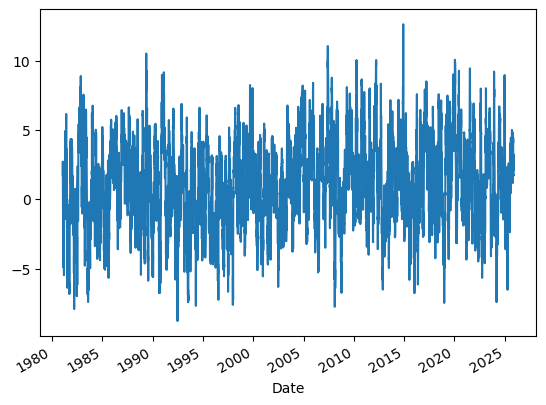

In [216]:
apples_sharpe = sharpe_ratio(apple)

apples_sharpe

test = apple['Close'].pct_change().rolling(30).apply(sharpe_ratio)


test.plot()